In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as sps
from scipy.interpolate import interp1d

from solardatatools import DataHandler
from solardatatools.dataio import load_redshift_data
from solardatatools.algorithms import Dilation
from spcqe.quantiles import SmoothPeriodicQuantiles

In [35]:
sns.set_theme(context="notebook")
dist = sps.norm()

# Load data

In [4]:
query = {
    'siteid': 'TAEHC1041562',
    'api_key': os.environ.get('REDSHIFT_API_KEY'),
    'sensor': 0
    }
df = load_redshift_data(**query)
dh = DataHandler(df, convert_to_ts=True)
dh.run_pipeline()

/opt/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meas_name = str(df_view[name_key][0])



            *********************************************
            * Solar Data Tools Data Onboarding Pipeline *
            *********************************************

            This pipeline runs a series of preprocessing, cleaning, and quality
            control tasks on stand-alone PV power or irradiance time series data.
            After the pipeline is run, the data may be plotted, filtered, or
            further analyzed.

            Authors: Bennet Meyers and Sara Miskovich, SLAC

            (Tip: if you have a mosek [https://www.mosek.com/] license and have it
            installed on your system, try setting solver='MOSEK' for a speedup)

            This material is based upon work supported by the U.S. Department
            of Energy's Office of Energy Efficiency and Renewable Energy (EERE)
            under the Solar Energy Technologies Office Award Number 38529.

            


task list:   0%|                                          | 0/7 [00:00<?, ?it/s]/opt/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if avg_day[0] >= thresh:
/opt/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if avg_day[-1] >= thresh:
/opt/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/matrix_embedding.py:41: FutureWarning: Second.delta is deprecated and will be removed in a future version. Use pd.



total time: 6.56 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              2.89s
Cleaning                   0.17s
Filtering/Summarizing      3.49s
    Data quality           0.10s
    Clear day detect       0.19s
    Clipping detect        1.83s
    Capacity change detect 1.38s



In [5]:
nvals_dil = 101
dil = Dilation(dh)
sig = dil.signal_dil
mat = sig[1:].reshape((nvals_dil, dil.ndays), order='F')
mat[:,~dh.daily_flags.no_errors] = np.nan
sig[1:] = mat.ravel(order='F')

# Transform data

In [27]:
q1 = np.linspace(0, 1, 11)
q1[0] = 0.02
q1[-1] = 0.98

spq = SmoothPeriodicQuantiles(
        num_harmonics=[12, 3],
        periods=[nvals_dil, 365.24225*nvals_dil],
        standing_wave=[True, False],
        trend=False,
        quantiles=q1,
        weight=10,
        problem='sequential',
        solver='qss',
        extrapolate='solar',
    )
spq.fit(sig)

100%|███████████████████████████████████████████| 11/11 [09:04<00:00, 49.52s/it]


In [28]:
transf = spq.transform(sig)
inv = spq.inverse_transform(transf)

# Test & Plot transformed data

In [29]:
# Check that the transformation + inverse transformation is correct
maxerr_abs = np.nanmax(np.abs(sig - inv))
maxerr_rel = np.nanmax(np.abs(sig - inv) / np.nanmean(np.abs(sig)))
print(f'Maximum absolute error: {maxerr_abs:.3e}')
print(f'Maximum relative error: {maxerr_rel * 100:.3e}%')

Maximum absolute error: 2.620e-12
Maximum relative error: 1.829e-10%


In [30]:
# Remove night-time data
transf_day = transf.copy()
transf_day[::nvals_dil] = np.nan

In [31]:
# Min and max values, should be around +/- 4.5
print("Minimum", np.round(np.nanmin(transf_day), 3), "and maximum", np.round(np.nanmax(transf_day), 3))

Minimum -4.019 and maximum 4.242


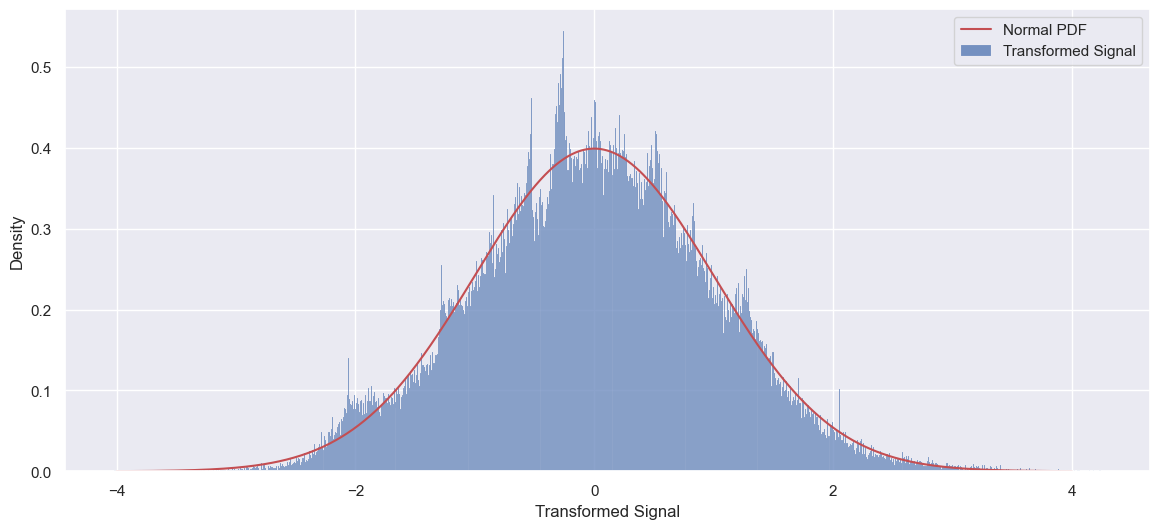

In [32]:
# Plot pdf
spq.plot_pdf(transf_day);

In [36]:
# Number of outliers
qo = 0.0001
x = np.round(dist.ppf(qo), 2)
nexp = np.round(len(sig) * qo, 3)
print("Normal distribution: expect", nexp, "positive and", nexp, "negative outliers.")
print("Asymptote extrapolation:", np.sum(transf_day>-x), "positive and", np.sum(transf_day<x), "negative outliers.")

Normal distribution: expect 12.958 positive and 12.958 negative outliers.
Asymptote extrapolation: 34 positive and 4 negative outliers.


In [37]:
# Perform a Kolmogorov-Smirnov test to compare the transformed signal to a standard normal distribution
transf_day_nonan = transf_day[~np.isnan(transf_day)]
ks_stat, p_value = sps.kstest(transf_day_nonan, 'norm')
print(f'KS statistic: {ks_stat:.3f}, p-value: {p_value:.3e}')

KS statistic: 0.006, p-value: 9.611e-05


The KS statistic quantifies the distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution (standard normal in this case). A smaller KS statistic indicates that the sample distribution is closer to the reference distribution.

The p-value indicates the probability of observing the data if the null hypothesis is true (i.e., the sample comes from the reference distribution). A low p-value (typically < 0.05) suggests that the sample does not come from the reference distribution.

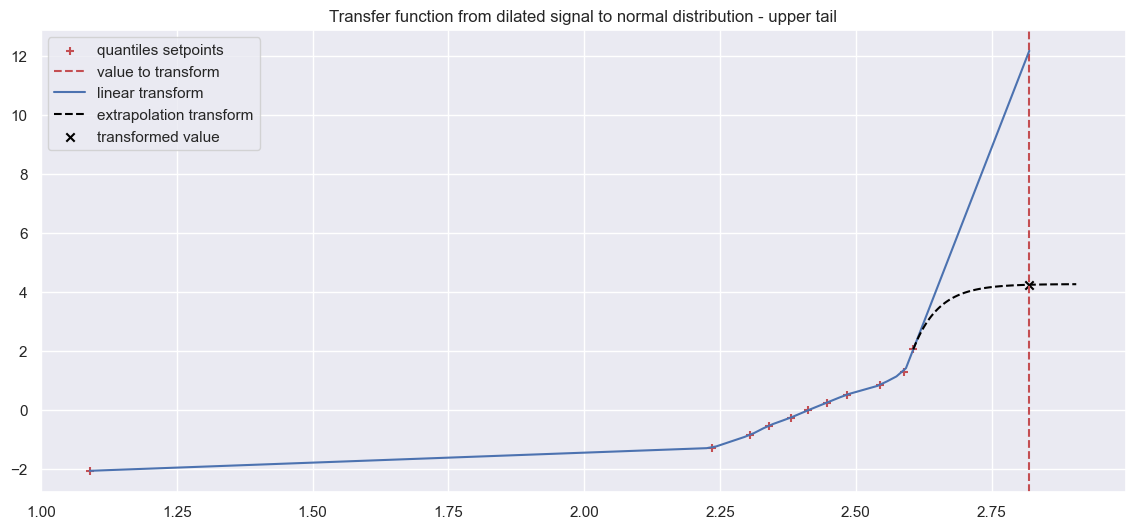

In [38]:
# Plot transformation - upper tail
idx = np.nanargmax(transf)
spq.plot_tail_transformation(sig, transf, 'upper', idx, 0.3);

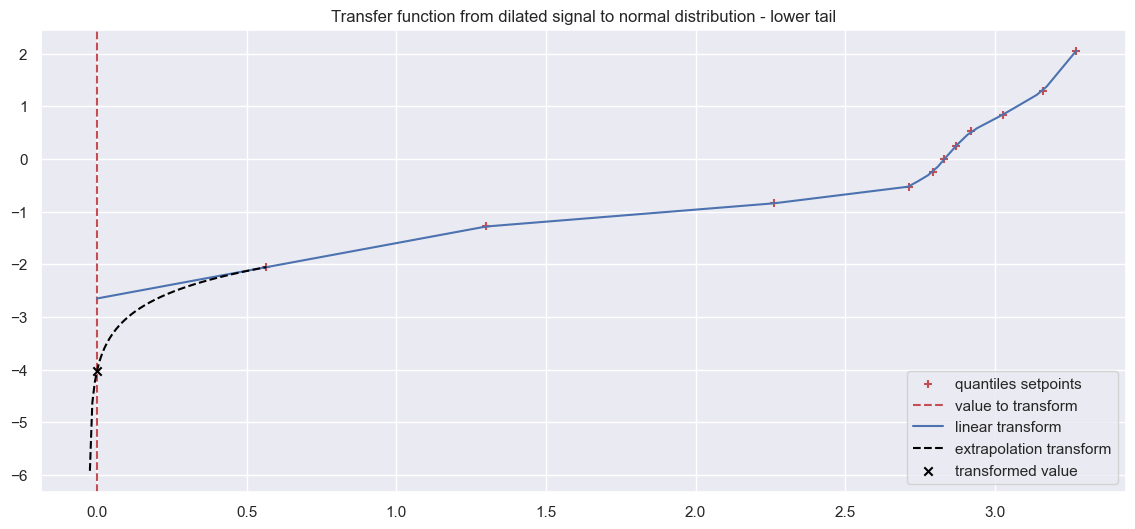

In [39]:
# Plot transformation - lower tail
idx = np.nanargmin(transf)
spq.plot_tail_transformation(sig, transf, 'lower', idx, 0.8);

# Linear option

In [40]:
extrapolate = 'linear'

spq_lin = SmoothPeriodicQuantiles(
        num_harmonics=[12, 3],
        periods=[nvals_dil, 365.24225*nvals_dil],
        standing_wave=[True, False],
        trend=False,
        quantiles=q1,
        weight=10,
        problem='sequential',
        solver='qss',
        extrapolate=extrapolate,
    )
spq_lin.fit(sig)

transf_lin = spq_lin.transform(sig)
inv_lin = spq_lin.inverse_transform(transf_lin)

100%|███████████████████████████████████████████| 11/11 [08:53<00:00, 48.48s/it]


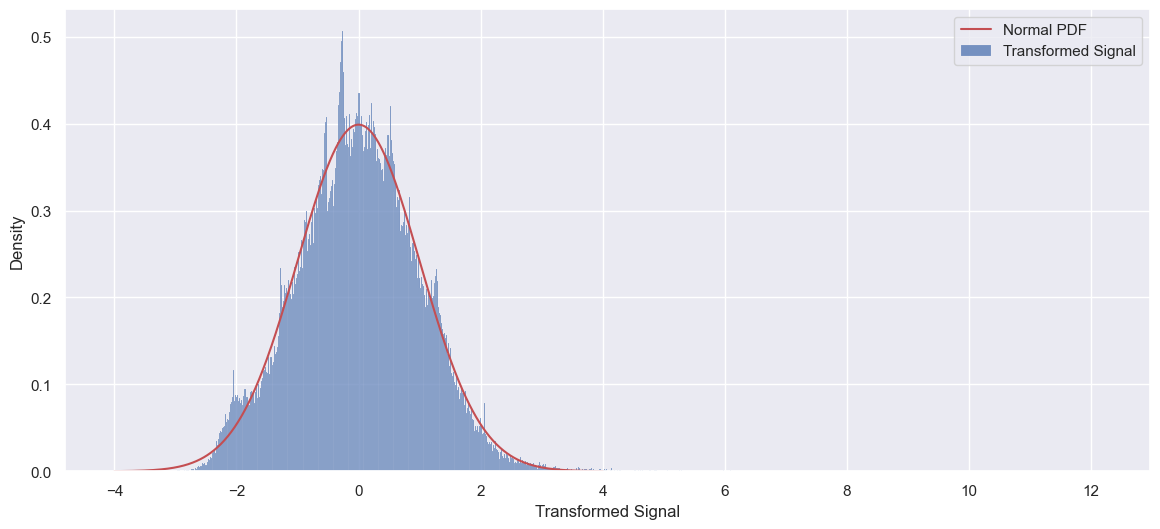

In [41]:
# Remove night-time data
transf_day_lin = transf_lin.copy()
transf_day_lin[::nvals_dil] = np.nan

# Plot pdf
spq_lin.plot_pdf(transf_day_lin);

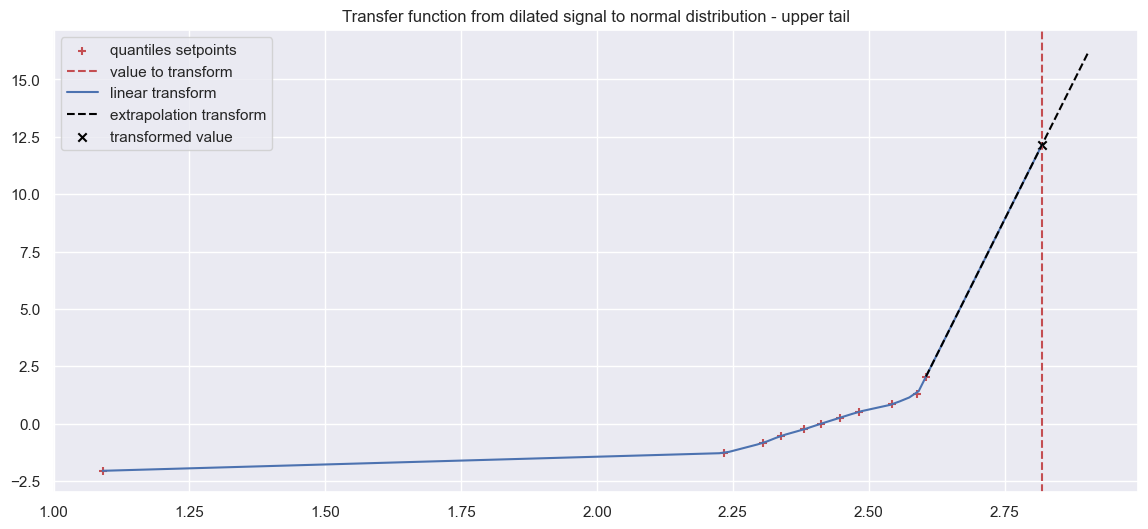

In [42]:
# Plot transformation - upper tail
idx = np.nanargmax(transf_lin)
spq_lin.plot_tail_transformation(sig, transf_lin, 'upper', idx, 0.3);